In [76]:
import warnings
import pandas as pd
import numpy as np
import lightgbm as lgb
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')


In [77]:
df1=pd.read_csv('area_passenger_index.csv',header=None
                ,names=['ID','time','people_index'])
df2=pd.read_csv('area_passenger_info.csv',header=None
                ,names=['ID','area_name','area_type','Center_x','Center_y','Grid_x','Grid_y','area'])
df3=pd.read_csv('migration_index.csv',header=None
            ,names=['date','departure_province','departure_city','arrival_province','arrival_city','index'])
df4=pd.read_csv('datafountain_competition_od.txt',sep='\t',header=None
                ,names=['hour','start_grid_x','start_grid_y','end_grid_x','end_grid_y','Index'])
sub=pd.read_csv('test_submit_example.csv',header=None
                ,names=['ID','time','people_index'])
df5 = pd.read_csv('area_relation.csv', index_col=0)

In [78]:
df5

,area_id,hour,r_in,r_out
0,0,0.0,353.5,312.9
1,1,0.0,0.4,0.4
2,2,0.0,0.8,1.2
3,3,0.0,0.0,0.0
4,4,0.0,0.0,0.0
...,...,...,...,...
23947,993,23.0,0.0,0.0
23948,994,23.0,0.5,0.5
23949,995,23.0,0.5,0.3
23950,996,23.0,0.0,0.0


In [79]:
cols = [x for x in df5.index if df5.loc[x, 'area_id'] == 0]
df5.drop(cols)

,area_id,hour,r_in,r_out
1,1,0.0,0.4,0.4
2,2,0.0,0.8,1.2
3,3,0.0,0.0,0.0
4,4,0.0,0.0,0.0
5,5,0.0,0.0,0.0
...,...,...,...,...
23947,993,23.0,0.0,0.0
23948,994,23.0,0.5,0.5
23949,995,23.0,0.5,0.3
23950,996,23.0,0.0,0.0


In [80]:
df1['time']=pd.to_datetime(df1['time'],format='%Y%m%d%H')
df1['day']=df1['time'].dt.day.apply(lambda x:x-17 if x>=17 else x+14)
df1['weekday']=df1['time'].dt.weekday
df1['hour']=df1['time'].dt.hour

In [81]:
dict_wd=dict(df1.groupby(['weekday']).mean()['people_index'])
dict_h=dict(df1.groupby(['hour']).mean()['people_index'])
dict_id=dict(df1.groupby(['ID']).mean()['people_index'])

In [82]:
df1['weekday_encoded']=df1['weekday'].map(dict_wd)
df1['hour_encoded']=df1['hour'].map(dict_h)
df1['ID_encoded']=df1['ID'].map(dict_id)

In [83]:
pd.set_option('display.width',None)

In [84]:
train_data=df1.copy()

In [85]:
train_data=pd.merge(df1,df2,on=['ID'])

In [86]:
dict_at=dict(train_data.groupby(['area_type']).mean()['people_index'])

In [87]:
train_data['area_type_encoded']=train_data['area_type'].map(dict_at)

In [88]:
train_data.drop(['area_name','area_type'],axis=1,inplace=True)
train_data.head()

,ID,time,people_index,day,weekday,hour,weekday_encoded,hour_encoded,ID_encoded,Center_x,Center_y,Grid_x,Grid_y,area,area_type_encoded
0,1,2020-01-17 00:00:00,1.8,0,4,0,28.266556,12.499074,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021
1,1,2020-01-17 01:00:00,1.5,0,4,1,28.266556,8.617108,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021
2,1,2020-01-17 02:00:00,1.3,0,4,2,28.266556,7.245714,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021
3,1,2020-01-17 03:00:00,1.3,0,4,3,28.266556,6.373882,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021
4,1,2020-01-17 04:00:00,1.7,0,4,4,28.266556,6.205978,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021


In [89]:
df3['date']=pd.to_datetime(df3['date'],format='%Y%m%d')
df3['day_encode']=df3['date'].dt.day.apply(lambda x:x-17 if x>=17 else x+14)
df3['city']=df3['arrival_city'].apply(lambda x:1 if x=='北京市' else 0)

inbj=df3[df3['city']==1]
outbj=df3[df3['city']==0]
index_mean_in=inbj.groupby(['date']).mean()['index']
index_std_in=inbj.groupby(['date']).std()['index']


index_mean_in_copy=index_mean_in.copy()
index_mean_in_copy.index=np.arange(30)
dict4=dict(index_mean_in_copy)
index_std_in_copy=index_std_in.copy()
index_std_in_copy.index=np.arange(30)
dict5=dict(index_std_in_copy)
index_mean_out=outbj.groupby(['date']).mean()['index']
index_std_out=outbj.groupby(['date']).std()['index']
index_mean_out_copy=index_mean_out.copy()
index_mean_out_copy.index=np.arange(30)
dict6=dict(index_mean_out_copy)
index_std_out_copy=index_std_out.copy()
index_std_out_copy.index=np.arange(30)
dict7=dict(index_std_out_copy)
train_data['index_mean_in']=train_data['day'].map(dict4)
train_data['index_std_in']=train_data['day'].map(dict5)
train_data['index_mean_out']=train_data['day'].map(dict6)
train_data['index_std_out']=train_data['day'].map(dict7)


In [90]:
ar_model1=AR(index_mean_in).fit()
pred_index_mean_in=ar_model1.predict('20200216','20200224',dynamic=True)
ar_model3=AR(index_mean_out).fit()
pred_index_mean_out=ar_model3.predict('20200216','20200224',dynamic=True)
ar_model2=AR(index_std_in).fit()
pred_index_std_in=ar_model2.predict('20200216','20200224',dynamic=True)
ar_model4=AR(index_std_out).fit()
pred_index_std_out=ar_model4.predict('20200216','20200224',dynamic=True)
dict_hi=dict(df4.groupby(['hour']).mean()['Index'])
train_data['hi_encoded']=train_data['hour'].map(dict_hi)

In [91]:
test_data=sub.copy()
test_data.drop(['people_index'],axis=1,inplace=True)
test_data['time']=pd.to_datetime(test_data['time'],format='%Y%m%d%H')
test_data['weekday']=test_data['time'].dt.weekday
test_data['hour']=test_data['time'].dt.hour
test_data['weekday_encoded']=test_data['weekday'].map(dict_wd)
test_data['hour_encoded']=test_data['hour'].map(dict_h)
test_data['ID_encoded']=test_data['ID'].map(dict_id)
test_data['day']=test_data['time'].dt.day.apply(lambda x:x+14)
pred_index_mean_in.index=np.arange(30,39,1)
dict_pim=dict(pred_index_mean_in)
pred_index_std_in.index=np.arange(30,39,1)
dict_pis=dict(pred_index_std_in)

pred_index_mean_out.index=np.arange(30,39,1)
dict_pim1=dict(pred_index_mean_out)
pred_index_std_out.index=np.arange(30,39,1)
dict_pis1=dict(pred_index_std_out)

In [92]:
test_data['index_mean_in']=test_data['day'].map(dict_pim)
test_data['index_std_in']=test_data['day'].map(dict_pis)
test_data['index_mean_out']=test_data['day'].map(dict_pim1)
test_data['index_std_out']=test_data['day'].map(dict_pis1)
test_data=pd.merge(test_data,df2,on=['ID'])
test_data.drop(['Center_x','Center_y','Grid_x','Grid_y'],axis=1,inplace=True)
test_data['hi_encoded']=test_data['hour'].map(dict_hi)
test_data['area_type_encoded']=test_data['area_type'].map(dict_at)
test_data.drop(['time','weekday','day','area_name','area_type'],axis=1,inplace=True)
train_data=train_data[train_data['day']>=16]
train_data.index=np.arange(train_data.shape[0])
target=train_data['people_index']

In [93]:
train_data.drop(['people_index','day','weekday', 'Center_x','Center_y','Grid_x','Grid_y','time']
                ,axis=1,inplace=True)
print('train_data.head()\n',train_data.head())
test_new=pd.DataFrame([test_data['ID']
                     ,test_data['hour']
                     ,test_data['weekday_encoded']#周几平均
                     ,test_data['hour_encoded']#小时平均
                     ,test_data['ID_encoded']#区域平均
                     ,test_data['area']#区域面积
                     ,test_data['area_type_encoded']#区域类型平均
                     ,test_data['index_mean_in']#迁入平均
                     ,test_data['index_std_in']#迁入方差
                     ,test_data['index_mean_out']#迁出平均
                     ,test_data['index_std_out']#迁出方差
                     ,test_data['hi_encoded']]).T#网格间流动小时平均
print('test_new.head()\n',test_new.head())

train_data.head()
    ID  hour  weekday_encoded  hour_encoded  ID_encoded           area  \
0   1     0        27.552537     12.499074    4.835556  395925.609375   
1   1     1        27.552537      8.617108    4.835556  395925.609375   
2   1     2        27.552537      7.245714    4.835556  395925.609375   
3   1     3        27.552537      6.373882    4.835556  395925.609375   
4   1     4        27.552537      6.205978    4.835556  395925.609375   

   area_type_encoded  index_mean_in  index_std_in  index_mean_out  \
0          10.071021       0.016892      0.042052        0.003928   
1          10.071021       0.016892      0.042052        0.003928   
2          10.071021       0.016892      0.042052        0.003928   
3          10.071021       0.016892      0.042052        0.003928   
4          10.071021       0.016892      0.042052        0.003928   

   index_std_out  hi_encoded  
0       0.015576    0.111379  
1       0.015576    0.110136  
2       0.015576    0.109777  
3  

,weekday_encoded,hour_encoded,ID_encoded,area,area_type_encoded,index_mean_in,index_std_in,index_mean_out,index_std_out,hi_encoded
0,27.552537,12.499074,4.835556,395925.609375,10.071021,0.016892,0.042052,0.003928,0.015576,0.111379
1,27.552537,8.617108,4.835556,395925.609375,10.071021,0.016892,0.042052,0.003928,0.015576,0.110136
2,27.552537,7.245714,4.835556,395925.609375,10.071021,0.016892,0.042052,0.003928,0.015576,0.109777
3,27.552537,6.373882,4.835556,395925.609375,10.071021,0.016892,0.042052,0.003928,0.015576,0.107989
4,27.552537,6.205978,4.835556,395925.609375,10.071021,0.016892,0.042052,0.003928,0.015576,0.106042
...,...,...,...,...,...,...,...,...,...,...
334987,26.135403,31.906556,0.001667,39963.562500,8.648456,0.004526,0.015719,0.002459,0.015534,0.108056
334988,26.135403,28.783407,0.001667,39963.562500,8.648456,0.004526,0.015719,0.002459,0.015534,0.108469
334989,26.135403,25.377081,0.001667,39963.562500,8.648456,0.004526,0.015719,0.002459,0.015534,0.108725
334990,26.135403,21.086499,0.001667,39963.562500,8.648456,0.004526,0.015719,0.002459,0.015534,0.109927


In [94]:
test_new

,ID,hour,weekday_encoded,hour_encoded,ID_encoded,area,area_type_encoded,index_mean_in,index_std_in,index_mean_out,index_std_out,hi_encoded
0,1.0,0.0,27.552537,12.499074,4.835556,395925.609375,10.071021,0.004731,0.029124,0.002587,0.01497,0.111379
1,1.0,1.0,27.552537,8.617108,4.835556,395925.609375,10.071021,0.004731,0.029124,0.002587,0.01497,0.110136
2,1.0,2.0,27.552537,7.245714,4.835556,395925.609375,10.071021,0.004731,0.029124,0.002587,0.01497,0.109777
3,1.0,3.0,27.552537,6.373882,4.835556,395925.609375,10.071021,0.004731,0.029124,0.002587,0.01497,0.107989
4,1.0,4.0,27.552537,6.205978,4.835556,395925.609375,10.071021,0.004731,0.029124,0.002587,0.01497,0.106042
...,...,...,...,...,...,...,...,...,...,...,...,...
215347,997.0,19.0,28.212716,31.906556,0.001667,39963.562500,8.648456,-0.005504,0.029653,0.002657,0.01495,0.108056
215348,997.0,20.0,28.212716,28.783407,0.001667,39963.562500,8.648456,-0.005504,0.029653,0.002657,0.01495,0.108469
215349,997.0,21.0,28.212716,25.377081,0.001667,39963.562500,8.648456,-0.005504,0.029653,0.002657,0.01495,0.108725
215350,997.0,22.0,28.212716,21.086499,0.001667,39963.562500,8.648456,-0.005504,0.029653,0.002657,0.01495,0.109927


In [95]:
cols = [idx for idx in df5.index if (df5.loc[idx,'area_id'] == 0)]
df5.drop(cols, inplace=True)

df5.sort_values(by=['area_id','hour'], inplace=True)
df5

,area_id,hour,r_in,r_out
1,1,0.0,0.4,0.4
999,1,1.0,0.8,0.2
1997,1,2.0,0.1,0.2
2995,1,3.0,0.3,0.7
3993,1,4.0,0.8,0.7
...,...,...,...,...
19959,997,19.0,0.0,0.0
20957,997,20.0,0.0,0.0
21955,997,21.0,0.0,0.0
22953,997,22.0,0.0,0.0


In [96]:
df5_train = pd.concat([df5]*14)

df5_train.area_id.values==train_data.ID.values
train_data['r_in'] = df5_train['r_in'].values
train_data['r_out'] = df5_train['r_out'].values
train_data.drop(['ID','hour'], axis=1)
train_data

,ID,hour,weekday_encoded,hour_encoded,ID_encoded,area,area_type_encoded,index_mean_in,index_std_in,index_mean_out,index_std_out,hi_encoded,r_in,r_out
0,1,0,27.552537,12.499074,4.835556,395925.609375,10.071021,0.016892,0.042052,0.003928,0.015576,0.111379,0.4,0.4
1,1,1,27.552537,8.617108,4.835556,395925.609375,10.071021,0.016892,0.042052,0.003928,0.015576,0.110136,0.8,0.2
2,1,2,27.552537,7.245714,4.835556,395925.609375,10.071021,0.016892,0.042052,0.003928,0.015576,0.109777,0.1,0.2
3,1,3,27.552537,6.373882,4.835556,395925.609375,10.071021,0.016892,0.042052,0.003928,0.015576,0.107989,0.3,0.7
4,1,4,27.552537,6.205978,4.835556,395925.609375,10.071021,0.016892,0.042052,0.003928,0.015576,0.106042,0.8,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334987,997,19,26.135403,31.906556,0.001667,39963.562500,8.648456,0.004526,0.015719,0.002459,0.015534,0.108056,0.0,0.0
334988,997,20,26.135403,28.783407,0.001667,39963.562500,8.648456,0.004526,0.015719,0.002459,0.015534,0.108469,0.0,0.0
334989,997,21,26.135403,25.377081,0.001667,39963.562500,8.648456,0.004526,0.015719,0.002459,0.015534,0.108725,0.0,0.0
334990,997,22,26.135403,21.086499,0.001667,39963.562500,8.648456,0.004526,0.015719,0.002459,0.015534,0.109927,0.0,0.0


In [97]:
df5_test = pd.concat([df5]*9)

df5_test.area_id.values==test_new.ID.values
test_new['r_in'] = df5_test['r_in'].values
test_new['r_out'] = df5_test['r_out'].values
test_new.drop(['ID','hour'], axis=1)
test_new

,ID,hour,weekday_encoded,hour_encoded,ID_encoded,area,area_type_encoded,index_mean_in,index_std_in,index_mean_out,index_std_out,hi_encoded,r_in,r_out
0,1.0,0.0,27.552537,12.499074,4.835556,395925.609375,10.071021,0.004731,0.029124,0.002587,0.01497,0.111379,0.4,0.4
1,1.0,1.0,27.552537,8.617108,4.835556,395925.609375,10.071021,0.004731,0.029124,0.002587,0.01497,0.110136,0.8,0.2
2,1.0,2.0,27.552537,7.245714,4.835556,395925.609375,10.071021,0.004731,0.029124,0.002587,0.01497,0.109777,0.1,0.2
3,1.0,3.0,27.552537,6.373882,4.835556,395925.609375,10.071021,0.004731,0.029124,0.002587,0.01497,0.107989,0.3,0.7
4,1.0,4.0,27.552537,6.205978,4.835556,395925.609375,10.071021,0.004731,0.029124,0.002587,0.01497,0.106042,0.8,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215347,997.0,19.0,28.212716,31.906556,0.001667,39963.562500,8.648456,-0.005504,0.029653,0.002657,0.01495,0.108056,0.0,0.0
215348,997.0,20.0,28.212716,28.783407,0.001667,39963.562500,8.648456,-0.005504,0.029653,0.002657,0.01495,0.108469,0.0,0.0
215349,997.0,21.0,28.212716,25.377081,0.001667,39963.562500,8.648456,-0.005504,0.029653,0.002657,0.01495,0.108725,0.0,0.0
215350,997.0,22.0,28.212716,21.086499,0.001667,39963.562500,8.648456,-0.005504,0.029653,0.002657,0.01495,0.109927,0.0,0.0


Training until validation scores don't improve for 20 rounds
[10]	train's l2: 707.353	train's score: 0.036237	valid's l2: 791.99	valid's score: 0.0343144
[20]	train's l2: 216.595	train's score: 0.0636246	valid's l2: 239.968	valid's score: 0.0606395
[30]	train's l2: 103.021	train's score: 0.0896868	valid's l2: 109.771	valid's score: 0.0871295
[40]	train's l2: 71.6291	train's score: 0.10567	valid's l2: 74.6026	valid's score: 0.103764
[50]	train's l2: 59.6887	train's score: 0.114602	valid's l2: 61.4059	valid's score: 0.113171
[60]	train's l2: 54.0461	train's score: 0.119737	valid's l2: 55.4407	valid's score: 0.118401
[70]	train's l2: 49.9833	train's score: 0.123917	valid's l2: 51.1219	valid's score: 0.1227
[80]	train's l2: 47.2264	train's score: 0.12703	valid's l2: 48.2869	valid's score: 0.125804
[90]	train's l2: 45.1007	train's score: 0.129606	valid's l2: 46.2564	valid's score: 0.128185
[100]	train's l2: 43.4202	train's score: 0.131763	valid's l2: 44.7767	valid's score: 0.130013
[110]	tr

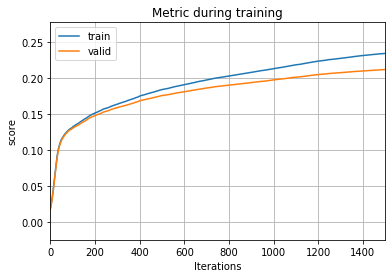

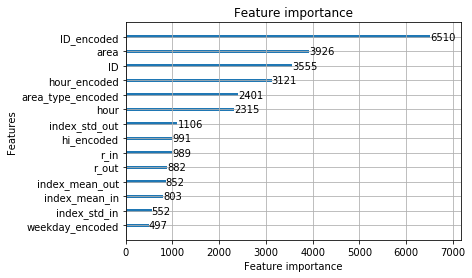

In [98]:
def score(y_true, y_pred):
    return 'score',1/(mean_squared_error(y_true,y_pred)**0.5+1), True

model_lgb=lgb.LGBMRegressor(num_leaves=20
                            ,max_depth=6
                            ,learning_rate=0.08
                            ,n_estimators=1500#最大生成树数量
                            ,device='gpu', gpu_platform_id=0, gpu_device_id=0)#使用GPU进行计算
x_train,x_test,y_train,y_test=train_test_split(train_data,target,test_size=0.2, shuffle=True)
model_lgb.fit(x_train,y_train, eval_set=[(x_train, y_train),(x_test, y_test)],eval_names=['train', 'valid'], eval_metric=score, early_stopping_rounds=20, verbose=10)
y_hat=model_lgb.predict(x_test)
y_hat[y_hat<0]=0
print(1/(mean_squared_error(y_test,y_hat)**0.5+1))
keys=[]

from lightgbm import plot_metric, plot_importance

lgb.plot_metric(model_lgb)
lgb.plot_importance(model_lgb)




In [99]:
sk=KFold(n_splits=10,shuffle=True )
for train,test in sk.split(train_data,target):
    x_train=train_data.iloc[train]
    y_train=target.iloc[train]
    x_test=train_data.iloc[test]
    y_test=target.iloc[test]
    model_lgb.fit(x_train,y_train)
    y_hat=model_lgb.predict(x_test)
    y_hat[y_hat<0]=0
    print(1/(mean_squared_error(y_test,y_hat)**0.5+1))
    keys.append(model_lgb.predict(test_new))
    
keys=np.array(keys)
km=keys.mean(axis=0)
km[km<0]=0
sub.iloc[:,2]=km

sub.to_csv('result.csv',encoding='utf-8',header=None,index=None)

0.20664099900552532
0.21634138237140432
0.20714711944310987
0.20905520076580666
0.2067656245034646
0.2135584019884157
0.21664584767661357
0.20370770195012147
0.21233896834040317
0.20414175981889587
